# Develop and train a neural network model with PyTorch on the BBBP dataset used in HW5 by using Morgan fingerprints.  Please explore a few model architectures  and compare your results with the default random forest model that have been developed in HW5.

In [1]:
!pip install scikit-learn
!pip install rdkit-pypi

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/share/apps/python/3.8.6/intel/bin/python -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/share/apps/python/3.8.6/intel/bin/python -m pip install --upgrade pip' command.


# Step 1: Read BBBP.csv file

In [2]:
# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

# read BBBP.csv file
df = pd.read_csv('BBBP.csv')
df.head()

,num,name,p_np,smiles
0,1,Propanolol,1,[Cl].CC(C)NCC(O)COc1cccc2ccccc12
1,2,Terbutylchlorambucil,1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl
2,3,40730,1,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...
3,4,24,1,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C
4,5,cloxacillin,1,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...


# Step 2: Calculate morgan fingerprints

In [3]:
# define function to calculate morgan fingerprints
Morgan_fpts = []
p_np = []
for i in range(len(df)):
    mol = Chem.MolFromSmiles(df['smiles'][i])
    if mol != None:
        Morgan_fpts.append(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024))
        p_np.append(df['p_np'][i])

[23:39:50] Explicit valence for atom # 1 N, 4, is greater than permitted
[23:39:50] WARNING: not removing hydrogen atom without neighbors
[23:39:50] Explicit valence for atom # 6 N, 4, is greater than permitted
[23:39:50] WARNING: not removing hydrogen atom without neighbors
[23:39:50] WARNING: not removing hydrogen atom without neighbors
[23:39:50] WARNING: not removing hydrogen atom without neighbors
[23:39:50] WARNING: not removing hydrogen atom without neighbors
[23:39:50] WARNING: not removing hydrogen atom without neighbors
[23:39:50] WARNING: not removing hydrogen atom without neighbors
[23:39:50] Explicit valence for atom # 6 N, 4, is greater than permitted
[23:39:50] WARNING: not removing hydrogen atom without neighbors
[23:39:50] WARNING: not removing hydrogen atom without neighbors
[23:39:50] WARNING: not removing hydrogen atom without neighbors
[23:39:50] WARNING: not removing hydrogen atom without neighbors
[23:39:50] Explicit valence for atom # 11 N, 4, is greater than pe

In [4]:
# convert fingerprints to numpy array
Morgan_fpts = np.array(Morgan_fpts)

In [5]:
# convert p_np to numpy array
p_np = np.array(p_np)

# Step 3: Develop and train neural network

In [6]:
!pip install torch

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/share/apps/python/3.8.6/intel/bin/python -m pip install --upgrade pip' command.


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [8]:
# split data into training and test sets (80/20 split)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(Morgan_fpts, p_np, test_size=1./3, random_state=1)

/home/ac7407/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/ac7407/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/ac7407/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/ac7407/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [9]:
# print length of each set
print("Training set size: ", len(X_train))
print("Test set size: ", len(X_test))

Training set size:  1359
Test set size:  680


In [10]:
# standardize the features
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

X_train_norm = (Morgan_fpts - np.mean(Morgan_fpts, axis=0)) / np.std(Morgan_fpts, axis=0)
X_train_norm = torch.from_numpy(X_train_norm).float()
y_train = torch.from_numpy(p_np).float()
train_ds = TensorDataset(X_train_norm, y_train)
batch_size = 1
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [11]:
# define neural network architecture with multi-layer perceptron (MLP) with several fully connected layers and ReLU activation functions
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return x

input_size = X_train_norm.shape[1]
hidden_size = 16
output_size = 3
model = Net(input_size, hidden_size, output_size)

In [12]:
# train model using training set
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 100
losses = []
for i in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb.float())
        loss = loss_fn(pred, yb.long())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if i % 10 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(i+1, epochs, loss.item()))
    losses.append(loss.item())

Epoch [1/100], Loss: 0.0048
Epoch [11/100], Loss: 0.0000
Epoch [21/100], Loss: 0.0004
Epoch [31/100], Loss: 0.0000
Epoch [41/100], Loss: 0.0000
Epoch [51/100], Loss: 0.0000
Epoch [61/100], Loss: 0.0000
Epoch [71/100], Loss: 0.0000
Epoch [81/100], Loss: 0.0000
Epoch [91/100], Loss: 0.0000


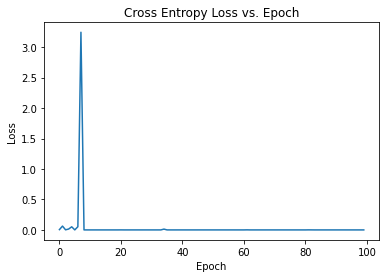

In [13]:
# plot loss vs. epoch
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Cross Entropy Loss vs. Epoch')
plt.show()

# Step 4: Evaluate neural network on test set

In [14]:
# evaluate model on the test dataset
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)
X_test_norm = torch.from_numpy(X_test_norm).float()
y_test = torch.from_numpy(y_test)
pred_test = model(X_test_norm)
correct = (torch.argmax(pred_test, dim=1) == y_test).type(torch.float)
accuracy = correct.mean()
print('Accuracy: ', accuracy.item())

Accuracy:  0.8323529362678528


# Step 5: Compare with random forest

In [15]:
# compare with random forest classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
rf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=42)
rf.fit(Morgan_fpts, p_np)

RandomForestClassifier(max_depth=2, random_state=42)

In [16]:
# predict p_np values for test set
pred = rf.predict(Morgan_fpts)

In [17]:
# calculate AUC
auc = roc_auc_score(p_np, pred)
print("AUC: ", auc)

AUC:  0.5816665328408543


## Compared with the random forest model (see HW5c), the accuracy obtained from using a neural network of 83.2% is higher than the random forest model (~58.2%).